In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
!cp /content/drive/MyDrive/Colab_Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [4]:
!pwd

/content


In [5]:
!kaggle datasets download -d sumanthvrao/daily-climate-time-series-data


  0% 0.00/22.0k [00:00<?, ?B/s]
100% 22.0k/22.0k [00:00<00:00, 24.8MB/s]


In [6]:
!unzip /content/daily-climate-time-series-data.zip && rm /content/daily-climate-time-series-data.zip

Archive:  /content/daily-climate-time-series-data.zip
  inflating: DailyDelhiClimateTest.csv  
  inflating: DailyDelhiClimateTrain.csv  


In [7]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [8]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv')

data_train['date'] = pd.to_datetime(data_train['date'], infer_datetime_format=True)
indexedDataset = data_train.set_index(['date'])

In [9]:
from datetime import datetime

indexedDataset = indexedDataset.drop(columns=['humidity', 'wind_speed', 'meanpressure'], axis=1)
indexedDataset.tail()

,meantemp
date,
2016-12-28,17.217391
2016-12-29,15.238095
2016-12-30,14.095238
2016-12-31,15.052632
2017-01-01,10.000000


In [10]:
indexedDataset.tail()

,meantemp
date,
2016-12-28,17.217391
2016-12-29,15.238095
2016-12-30,14.095238
2016-12-31,15.052632
2017-01-01,10.000000


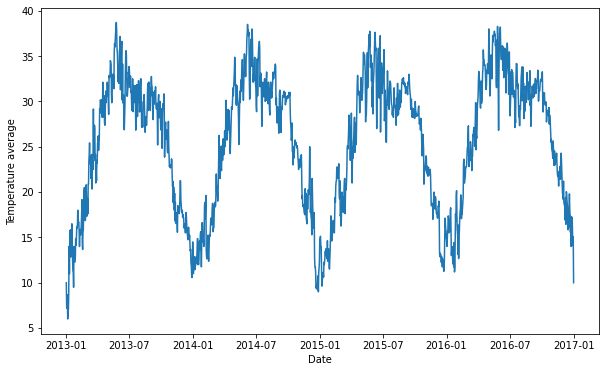

In [ ]:
plt.xlabel('Date')
plt.ylabel('Temperature average')
plt.plot(indexedDataset)

In [ ]:
rolmean = indexedDataset.rolling(window=365).mean()
rolstd = indexedDataset.rolling(window=365).std()
print(rolmean, rolstd)

             meantemp
date                 
2013-01-01        NaN
2013-01-02        NaN
2013-01-03        NaN
2013-01-04        NaN
2013-01-05        NaN
...               ...
2016-12-28  27.139585
2016-12-29  27.138868
2016-12-30  27.136389
2016-12-31  27.137316
2017-01-01  27.126357

[1462 rows x 1 columns]             meantemp
date                
2013-01-01       NaN
2013-01-02       NaN
2013-01-03       NaN
2013-01-04       NaN
2013-01-05       NaN
...              ...
2016-12-28  6.863074
2016-12-29  6.864308
2016-12-30  6.868865
2016-12-31  6.867207
2017-01-01  6.891379

[1462 rows x 1 columns]


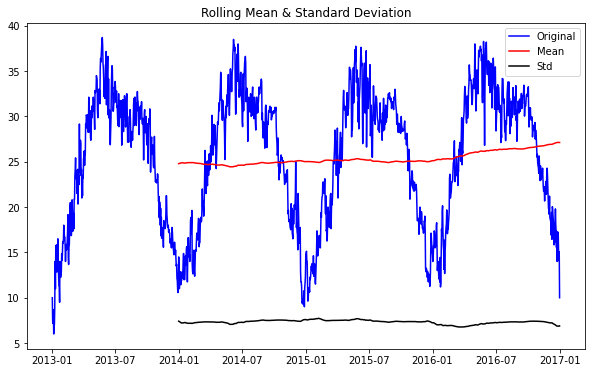

In [ ]:
orig = plt.plot(indexedDataset, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Mean')
std = plt.plot(rolstd, color='black', label='Std')

plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

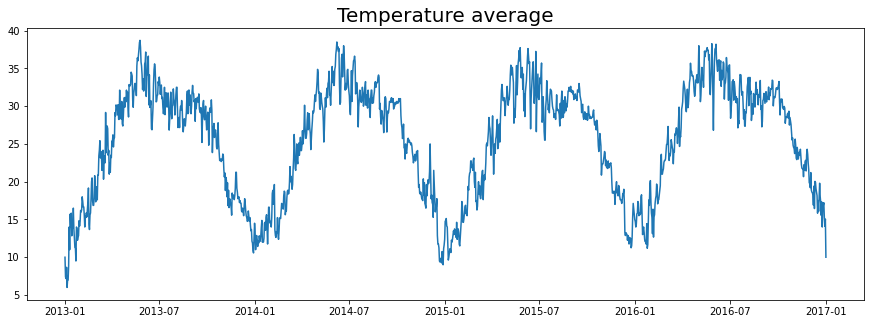

In [ ]:
dates = data_train['date'].values
temp = data_train['meantemp'].values

plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature average',
          fontsize=20);

In [ ]:
temp.shape

(1462,)

In [ ]:
indexedDataset.tail()

,meantemp
date,
2016-12-28,17.217391
2016-12-29,15.238095
2016-12-30,14.095238
2016-12-31,15.052632
2017-01-01,10.000000


In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [13]:
print(indexedDataset.meantemp.shape)
print(indexedDataset.meantemp)
print(type(indexedDataset.meantemp))

(1462,)
date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1462, dtype: float64
<class 'pandas.core.series.Series'>


In [14]:
train_set = windowed_dataset(indexedDataset.meantemp, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),

    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),

    tf.keras.layers.Dense(1),
])

In [15]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss = tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

history = model.fit(train_set, epochs=100)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


15/15 [==============================] - 6s 98ms/step - loss: 25.6455 - mae: 26.1455
Epoch 2/100
15/15 [==============================] - 1s 75ms/step - loss: 25.4583 - mae: 25.9583
Epoch 3/100
15/15 [==============================] - 1s 80ms/step - loss: 25.2526 - mae: 25.7526
Epoch 4/100
15/15 [==============================] - 1s 76ms/step - loss: 25.0817 - mae: 25.5817
Epoch 5/100
15/15 [==============================] - 1s 77ms/step - loss: 24.9419 - mae: 25.4419
Epoch 6/100
15/15 [==============================] - 1s 76ms/step - loss: 24.8121 - mae: 25.3121
Epoch 7/100
15/15 [==============================] - 1s 75ms/step - loss: 24.6822 - mae: 25.1822
Epoch 8/100
15/15 [==============================] - 2s 109ms/step - loss: 24.5440 - mae: 25.0440
Epoch 9/100
15/15 [==============================] - 2s 117ms/step - loss: 24.3910 - mae: 24.8910
Epoch 10/100
15/15 [==============================] - 1s 78ms/step - loss: 24.2179 - mae: 24.7179
Epoch 11/100
15/15 [===================

In [28]:
skala_data = (data_train['meantemp'].max() - data_train['meantemp'].min()) * 0.1
MAE = history.history['mae']
best_MAE = min(MAE)

print('skala data: ',skala_data)
print('MAE: ', best_MAE)
if best_MAE < skala_data:
  print('model good fit')
else:
  print('revisi model')

skala data:  3.2714285714285722
MAE:  1.4505128860473633
model good fit


In [ ]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)

NameError: ignored